In [1]:
from thllib import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
from thllib import util
import figurefirst as fifi
from scipy import signal

In [2]:
%matplotlib inline

In [3]:
fly = flb.NetFly(1530,rootpath='/media/imager/FlyDataD/FlyDB/')
fly.open_signals()

In [4]:
abf_sp = fly.abf_times[1] #abf spike period
ca_frame_in_abf = np.int(0.02/abf_sp) #abf period in abf idxs

#get the idx's where the ca data is aquired
ep_idx = np.where(np.array(fly.abf_led_pulse)>1.0)[0]

#get the idx's where the ca data is aquired
ep_idx = np.where(np.array(fly.abf_led_pulse)>1.0)[0]
start = ep_idx[0]+np.int(1.5*ca_frame_in_abf) #the calcium data starts at the end of one trigger period 
stop = ep_idx[-1]+np.int(1.5*ca_frame_in_abf)

#make a time array for the recording epoch
ep_times = np.array(fly.abf_times[start:stop])
ep_times -= ep_times[0]

#load this into memory since I will use it quite a bit
spike_sig = np.array(fly.abf_electrode[start:stop])
i1_ca = fly.ca_camera_left_model_fits['i1']
## another way of extracting b1 activity
#F_ = np.mean(fly.ca_camera_left[:,24:34,75:100],axis = (1,2))
#F = np.percentile(F_,0.01)
#DF_F = (F_-F)/F
#b1_ca = DF_F

In [5]:
spike_sig *= -1

In [6]:
#grab a spike pool
spike_idxs = util.idx_by_thresh(spike_sig,thresh = 2.5)
#filter out false positives here
#get_peaks
peak_idxs = [np.argmax(spike_sig[idx[0]-10:idx[-1]+10])+idx[0]-10 for idx in spike_idxs]

spike_idxs = spike_idxs[:-1]
peak_idxs = peak_idxs[:-1]

In [7]:
peak_times = ep_times[peak_idxs]

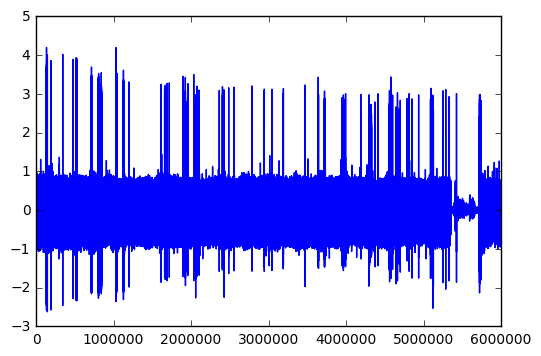

In [8]:
plt.plot(spike_sig)

In [9]:
time_mtrx = np.array([ep_times[idx-50:idx+50] for idx in peak_idxs])

In [10]:
#create an impulse train to represent the spikes
impulses = np.zeros_like(spike_sig)
impulses[peak_idxs] = 1

In [11]:
#?signal.resample

In [214]:
#put the ca data into the abf timebase
resampled_i1_ca,resampled_t = signal.resample(i1_ca,len(ep_times),
                                              np.array(fly.ca_camera_left_times),
                                              window = 'hanning')

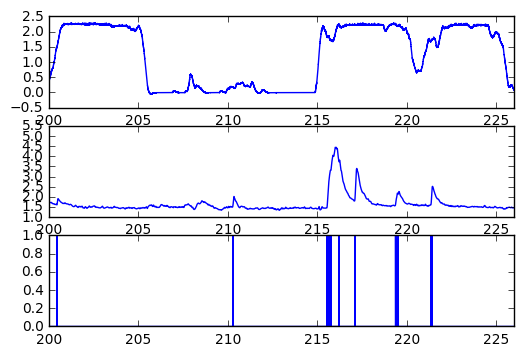

In [215]:
plt.subplot(3,1,1)
plt.plot(ep_times,fly.abf_freq[start:stop])
plt.gca().set_xbound(200,226)
plt.subplot(3,1,2)
plt.plot(resampled_t,resampled_i1_ca)
plt.gca().set_xbound(200,226)
plt.subplot(3,1,3)
plt.plot(resampled_t,impulses)
plt.gca().set_xbound(200,226)

In [217]:
sub_start =  np.argwhere((resampled_t >200))[0]
sub_stop = np.argwhere((resampled_t >226))[0]

In [218]:
sp = 20. #sample period ms
MK_TON1 = 10/1000. #ms
MK_TON2 = 10/1000. #ms
MK_TOFF1 = 100/1000. #ms
MK_TOFF2 = 300/1000.

def make_single_kernel(times,tauon1,tauoff1):
    kx = np.copy(times)
    kon1 = lambda x:np.exp(((-1*tauon1)/(x)))
    koff1 = lambda x:np.exp((-1*x)/tauoff1)
    k1 = (kon1(kx)*koff1(kx))
    return k1/np.max(k1)

In [219]:
kernel = make_single_kernel(resampled_t - resampled_t[0],0.01636028, 0.23604393)

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide


In [220]:
import local_project_functions as lpf

In [221]:
ca_sig = resampled_i1_ca[sub_start:sub_stop]
time_sig = resampled_t[sub_start:sub_stop]
time_sig -= time_sig[0]
freq_sig = fly.abf_freq[start:stop][sub_start:sub_stop]*100

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  if __name__ == '__main__':
/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  from ipykernel import kernelapp as app
/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [222]:
#flight_epoch_idx = np.squeeze(np.argwhere(np.squeeze(resampled_freq)>50))
potential_impulse_idxs = list()
#spike_idx = flight_epoch_idx[0]
spike_idx = 1
spike_time = time_sig[spike_idx]
#while(spike_idx < flight_epoch_idx[-1]):
while(spike_time<time_sig[-1]):
    spike_idx = np.argwhere(time_sig<spike_time)[-1][0]
    #print spike_idx
    potential_impulse_idxs.append(spike_idx)
    isi = 1./freq_sig[spike_idx]
    #print freq_sig[spike_idx]
    #print spike_time
    if (abs(isi) < 0.02):
        #print 'here'
        spike_time += isi
    else:
        spike_time += 0.005

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in divide


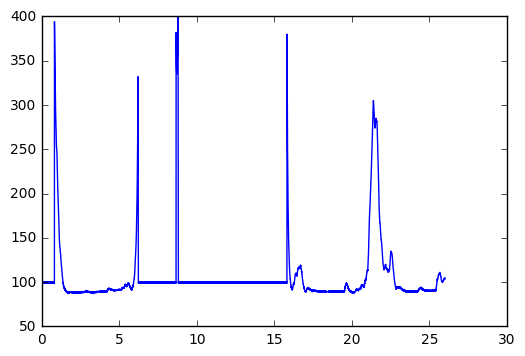

In [223]:
plt.plot(time_sig[potential_impulse_idxs[:-1]],np.diff(potential_impulse_idxs))
#plt.gca().set_xbound(50,2000)

In [224]:
def wiener_deconvolution(signal, kernel, snr):
    "lambd is the SNR"
    from scipy import fft,ifft
    kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length
    H = fft(kernel)
    deconvolved = np.real(ifft(fft(signal)*np.conj(H)/(H*np.conj(H) + snr**2)))
    return deconvolved

In [225]:
len(kernel)

5999983

In [226]:
recon_ca,recon_impulses = lpf.forward_optimize(ca_sig-np.min(ca_sig),
                     time_sig,
                     potential_impulse_idxs,
                     kernel,kernel_gain=0.098080808081)

In [227]:
wdeconv = wiener_deconvolution(ca_sig-np.min(ca_sig),kernel[:len(ca_sig)]*0.1,20.01)

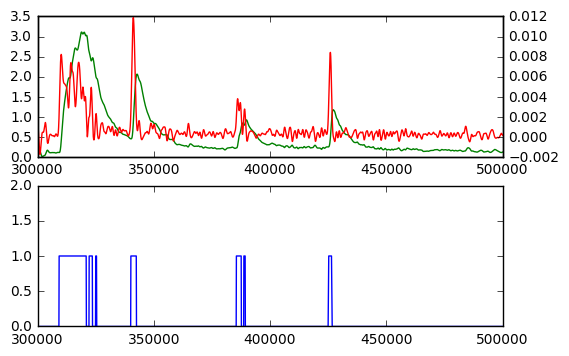

In [244]:
plt.subplot(2,1,1)
plt.plot(ca_sig-np.min(ca_sig),color = 'g')
plt.twinx()
plt.plot(wdeconv,color = 'r')
plt.gca().set_xbound(300000,500000)
plt.subplot(2,1,2)
plt.plot(potential_impulse_idxs,
         wdeconv[potential_impulse_idxs]>0.002)
plt.gca().set_xbound(300000,500000)
plt.gca().set_ybound(0,2)

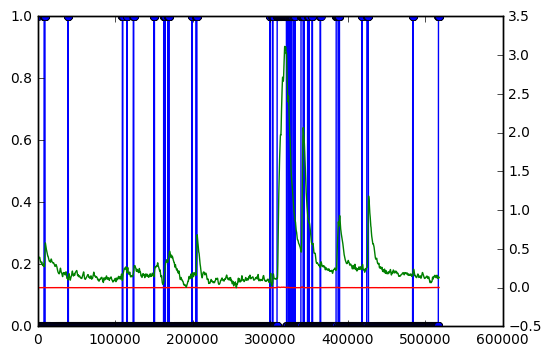

In [234]:

plt.twinx()
#plt.gca().set_xbound(0,50000)
plt.plot(ca_sig-np.min(ca_sig),color = 'g')


/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


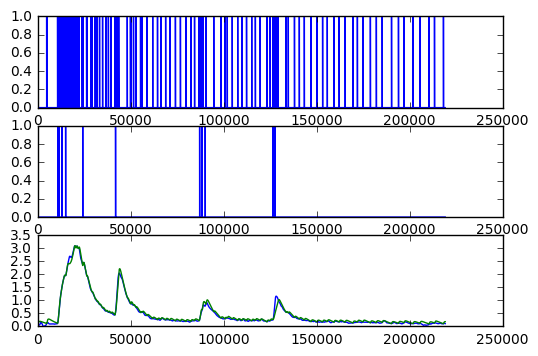

In [150]:
plt.subplot(3,1,1)
plt.plot(recon_impulses)
#plt.gca().set_xbound(20000,25000)
plt.subplot(3,1,2)
plt.plot(impulses[sub_start:sub_stop])
#plt.gca().set_xbound(20000,25000)
plt.subplot(3,1,3)
plt.plot(ca_sig-np.min(ca_sig))
plt.plot(recon_ca)
#plt.gca().set_xbound(20000,25000)

In [ ]:
padded_signal = np.zeros((len(impulses)))

In [136]:
res = 10
g1,g2,g3 = np.meshgrid(np.linspace(0.001,0.1,res),np.linspace(0.001,1,res),np.linspace(0.001,1,res))
errors = np.zeros(res*res*res)

T1 = 0.01636028
T2 = 0.23604393

df_f = (ca_sig-np.percentile(ca_sig,5))/np.percentile(ca_sig,5)
l = len(df_f)
i = 0
for T1,T2,kernel_gain in zip(g1.ravel(),g2.ravel(),g3.ravel()):
    kernel = make_single_kernel(time_sig,T1,T2)
    csig = scipy.signal.fftconvolve(impulses[sub_start:sub_stop],kernel*kernel_gain,'full')
    errors[i] = np.sum(np.abs(csig[:l]-df_f))
    #errors[i] = np.linalg.norm(csig[:l]-df_f)
    i += 1

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide
/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [138]:
errors = errors.reshape(res,res)
#errors[0,0] = 0

ValueError: total size of new array must be unchanged

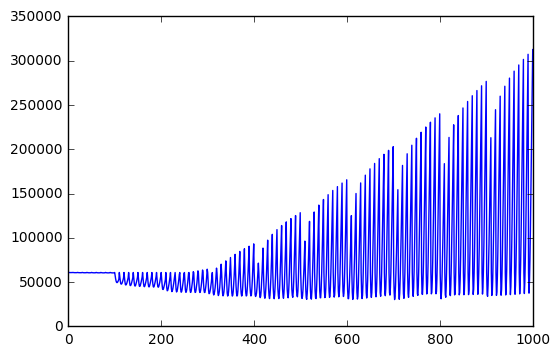

In [140]:
plt.plot(errors)

In [141]:
print g1.ravel()[np.argmin(errors)]
print g2.ravel()[np.argmin(errors)]
print g3.ravel()[np.argmin(errors)]

0.001
0.778
0.223


In [142]:
kernel = make_single_kernel(time_sig,0.001,0.778)
csig = scipy.signal.fftconvolve(impulses[sub_start:sub_stop],kernel*0.223,'full')

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide
/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  from ipykernel import kernelapp as app


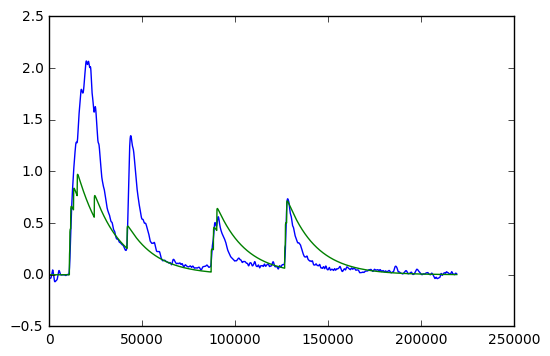

In [143]:
plt.plot(df_f)
plt.plot(csig[:len(ca_sig)])